# Contextual Synthetic Location Generation (Privacy-Preserving Traces)

## Project Overview

This project creates **fake GPS tracks that look like real people's movement but protect their privacy**. It's like generating realistic driving patterns without copying anyone's actual route.

### The Problem
Companies and researchers want to study how people move around cities, but they can't share real GPS data because it reveals sensitive information like where you live, work, and spend time.

### Our Solution
We teach a computer to learn movement patterns from real data, then generate new fake routes that follow the same patterns but aren't copies of real people's trips.

### Method: Markov Chain Model
We use a **Markov Chain** - it's like a smart system that remembers the last location and predicts where to go next based on what real people usually do.

#### How it works:
1. **Grid the city:** Split the area into squares (like a chess board)
2. **Learn patterns:** If someone is in square A, where do they usually go next?
3. **Add privacy noise:** Add random noise so it doesn't memorize exact routes  
4. **Generate fake routes:** Create new routes using these learned patterns
5. **Preserve context:** Keep important patterns like busy areas and rush hour timing

### Expected Results
Our fake routes should have the same:
- Busy areas (hotspots) as real data
- Rush hour patterns and timing
- Overall movement trends

But you **can't match them back to real people**, protecting individual privacy.

### Key Innovation
**Contextual constraints** - we make sure our fake data preserves useful aggregate patterns (like "downtown is busy at 9am") while hiding individual trajectories.

---

*This notebook demonstrates privacy-preserving synthetic data generation for location traces, balancing utility preservation with individual privacy protection.*


This notebook builds a minimal yet rigorous pipeline to generate synthetic GPS traces that preserve aggregate utility (hotspot/time-of-day distributions) while hiding exact user paths.

* It uses a Markov (n-gram) model over grid cells with optional Laplace noise on transitions, plus simple constraints to match marginals.
* It evaluates privacy-utility tradeoffs via KL divergence on spatial/temporal histograms and a re-identification risk proxy using nearest-neighbor distance between real and synthetic trajectories.

In [1]:
#@title Imports and config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
import itertools
import math
import random

np.random.seed(42)
random.seed(42)

# Global config
CONFIG = {
    "use_geolife_subset": False,   # set True if loading your own small Geolife CSV subset
    "grid_size": 20,               # grid cells per axis for synthetic grid mapping
    "area_km": 10.0,               # width/height of the square area (for toy data)
    "num_users": 50,               # number of synthetic real users to simulate (toy mode)
    "traj_len": 200,               # length of each trajectory in steps (toy mode)
    "time_bins": 24,               # hourly bins
    "markov_order": 1,             # 1st-order Markov over grid cells
    "laplace_noise_scale": 0.0,    # default; will sweep later (e.g., 0.0, 0.1, 0.3, 0.5)
    "temperature": 1.0,            # sampling temperature: >1 smoother, <1 sharper
    "num_synth_per_user": 1,       # generate 1 synthetic per real user
    "synth_len": 200,              # synthetic trajectory length
    "context_match_weight": 0.5,   # strength of temporal/spatial marginal reweighting
    "eval_k_neighbors": 1,         # nearest neighbor for risk proxy
}

plt.rcParams["figure.figsize"] = (6, 5)
sns.set(style="whitegrid", context="talk")


In [3]:
#@title Generate toy grid-walk dataset with hotspots and time-of-day patterns
# Data schema: list of trajectories; each trajectory is a dict:
# {"user_id": int, "t": [t0,...], "x": [x0,...], "y": [y0,...]}
# Coordinates are in kilometers within a square [0, area_km]^2

def generate_hotspots(area_km, n_hotspots=4, hotspot_strength=3.0):
    centers = np.random.uniform(0.2*area_km, 0.8*area_km, size=(n_hotspots, 2))
    return centers, hotspot_strength

def time_of_day_weights(time_bins):
    # Example: more movement in 8-10 and 17-19 bins
    w = np.ones(time_bins)
    for h in range(time_bins):
        if 7 <= h <= 10:
            w[h] *= 1.8
        if 17 <= h <= 19:
            w[h] *= 1.6
        if 0 <= h <= 5:
            w[h] *= 0.6
    return w / w.sum()

def step_prob(x, y, tbin, centers, hotspot_strength, area_km, step_sigma=0.5):
    # Unnormalized attractiveness around hotspots + time weights
    # Gaussian bumps around each hotspot
    attr = 0.0
    for cx, cy in centers:
        d2 = (x - cx)**2 + (y - cy)**2
        attr += math.exp(-d2 / (2.0 * (area_km/10)**2))
    attr = 1.0 + hotspot_strength * attr
    # Combine with random walk tendency
    return attr

def reflect_bounds(val, low, high):
    if val < low:
        return low + (low - val)
    if val > high:
        return high - (val - high)
    return val

def simulate_user_traj(area_km, T, centers, hotspot_strength, time_weights):
    # Start near a random hotspot
    cx, cy = centers[np.random.randint(len(centers))]
    x = np.clip(np.random.normal(cx, area_km/20), 0, area_km)
    y = np.clip(np.random.normal(cy, area_km/20), 0, area_km)
    traj = {"t": [], "x": [], "y": []}
    for t in range(T):
        tbin = t % len(time_weights)
        # Biased random walk: small step plus hotspot attraction
        theta = np.random.uniform(0, 2*np.pi)
        step = np.random.normal(loc=0.2, scale=0.15)  # mean step ~0.2km
        cand_x = x + step * math.cos(theta)
        cand_y = y + step * math.sin(theta)
        # Attraction toward nearest hotspot
        hc = centers[np.argmin(np.sum((centers - np.array([x, y]))**2, axis=1))]
        cand_x = 0.85*cand_x + 0.15*hc[0]
        cand_y = 0.85*cand_y + 0.15*hc[1]
        cand_x = reflect_bounds(cand_x, 0, area_km)
        cand_y = reflect_bounds(cand_y, 0, area_km)

        # Accept move with probability proportional to hotspot/time attraction
        p_accept = min(1.0, step_prob(cand_x, cand_y, tbin, centers, hotspot_strength, area_km))
        if np.random.rand() < p_accept:
            x, y = cand_x, cand_y

        traj["t"].append(t)
        traj["x"].append(x)
        traj["y"].append(y)
    return traj

def generate_dataset(num_users, T, area_km):
    centers, hs = generate_hotspots(area_km, n_hotspots=5, hotspot_strength=3.0)
    tw = time_of_day_weights(CONFIG["time_bins"])
    trajectories = []
    for u in range(num_users):
        tr = simulate_user_traj(area_km, T, centers, hs, tw)
        tr["user_id"] = u
        trajectories.append(tr)
    return trajectories, centers

real_trajs, hotspot_centers = generate_dataset(CONFIG["num_users"], CONFIG["traj_len"], CONFIG["area_km"])
print(f"Number of trajectories: {len(real_trajs)}, Length of first trajectory: {len(real_trajs[0]['t'])}")

Number of trajectories: 50, Length of first trajectory: 200


In [5]:
#@title Grid mapping utilities
def build_grid_mapper(area_km, grid_size):
    cell_size = area_km / grid_size
    def to_cell(x, y):
        i = int(np.clip(x / cell_size, 0, grid_size - 1))
        j = int(np.clip(y / cell_size, 0, grid_size - 1))
        return i, j
    def cell_id(i, j):
        return i * grid_size + j
    def from_cell(cell):
        i, j = divmod(cell, grid_size)
        x = (i + 0.5) * (area_km / grid_size)
        y = (j + 0.5) * (area_km / grid_size)
        return x, y
    return to_cell, cell_id, from_cell

to_cell, cell_id, from_cell = build_grid_mapper(CONFIG["area_km"], CONFIG["grid_size"])

def discretize_trajs(trajs, time_bins, to_cell, cell_id):
    disc = []
    for tr in trajs:
        ts = np.array(tr["t"])
        xs = np.array(tr["x"])
        ys = np.array(tr["y"])
        cells = []
        tbins = []
        for k in range(len(ts)):
            i,j = to_cell(xs[k], ys[k])
            cells.append(cell_id(i,j))
            tbins.append(ts[k] % time_bins)
        disc.append({"user_id": tr.get("user_id", -1), "cells": cells, "tbin": tbins})
    return disc

disc_real = discretize_trajs(real_trajs, CONFIG["time_bins"], to_cell, cell_id)
len(disc_real), len(disc_real[0]["cells"])


(50, 200)

In [7]:
#@title Estimate Markov transitions with smoothing and Laplace noise
def estimate_markov(disc_trajs, grid_size, time_bins, order=1, laplace_noise_scale=0.0):
    num_cells = grid_size * grid_size
    # counts[(tbin, from_cell, to_cell)] = count
    counts = defaultdict(int)
    from_totals = defaultdict(int)
    start_counts = defaultdict(int)  # for initial cell distribution per tbin

    for tr in disc_trajs:
        cells = tr["cells"]
        tbins = tr["tbin"]
        if len(cells) < 2:
            if len(cells) > 0:
                # Handle single-point trajectories for initial distribution
                start_counts[(tbins[0], cells[0])] += 1
            continue
        # Corrected: count start cell per tbin
        start_counts[(tbins[0], cells[0])] += 1

        for k in range(len(cells)-1):
            t = tbins[k]
            a = cells[k]
            b = cells[k+1]
            counts[(t, a, b)] += 1
            from_totals[(t, a)] += 1

    # Build transition matrices per tbin
    trans = {}
    for t in range(time_bins):
        trans[t] = np.zeros((num_cells, num_cells), dtype=float)
        for a in range(num_cells):
            denom = from_totals.get((t, a), 0)
            # Add-1 smoothing (Laplace smoothing)
            smoothed_counts_row = np.ones(num_cells, dtype=float) # Initialize with 1 for smoothing
            total_smoothed_denom = num_cells # Denominator for smoothing

            for b in range(num_cells):
                smoothed_counts_row[b] += counts.get((t, a, b), 0)
                total_smoothed_denom += counts.get((t, a, b), 0)

            if total_smoothed_denom == 0: # Should not happen with add-1 smoothing if num_cells > 0
                 continue

            row = smoothed_counts_row / total_smoothed_denom

            # Optional: add Laplace noise to log-probabilities
            if laplace_noise_scale > 0:
                # convert to log, add noise, renormalize
                with np.errstate(divide='ignore'):
                    logp = np.log(row + 1e-12) # Add small epsilon to avoid log(0)
                noise = np.random.laplace(loc=0.0, scale=laplace_noise_scale, size=num_cells)
                logp_pert = logp + noise
                # Ensure logp_pert values are not excessively large before exp
                logp_pert = np.clip(logp_pert, -50, 50) # Clip to avoid overflow with exp
                row = np.exp(logp_pert)
                row = row / (row.sum() + 1e-12) # Add epsilon to avoid division by zero

            trans[t][a, :] = row

    # Initial distribution per time bin
    init = {}
    for t in range(time_bins):
        row = np.zeros(num_cells)
        denom = 0
        for a in range(num_cells):
            c = start_counts.get((t, a), 0)
            row[a] = c + 1.0  # smoothing
            denom += c + 1.0
        if denom == 0:
            row[:] = 1.0
            denom = num_cells
        init[t] = row / denom

    return init, trans

init_dist, trans_mat = estimate_markov(
    disc_real,
    CONFIG["grid_size"],
    CONFIG["time_bins"],
    order=CONFIG["markov_order"],
    laplace_noise_scale=CONFIG["laplace_noise_scale"]
)

In [8]:
#@title Compute real marginals and build reweighting factors
def spatial_hist(trajs_disc, num_cells):
    h = np.zeros(num_cells)
    for tr in trajs_disc:
        for c in tr["cells"]:
            h[c] += 1
    h = h / max(h.sum(), 1e-12)
    return h

def temporal_hist(trajs_disc, time_bins):
    h = np.zeros(time_bins)
    for tr in trajs_disc:
        for t in tr["tbin"]:
            h[t] += 1
    h = h / max(h.sum(), 1e-12)
    return h

num_cells = CONFIG["grid_size"] * CONFIG["grid_size"]
real_spatial = spatial_hist(disc_real, num_cells)
real_temporal = temporal_hist(disc_real, CONFIG["time_bins"])

def build_context_weights(real_spatial, real_temporal, weight):
    # target multipliers proportional to real marginals^weight
    # normalize to mean 1 to avoid exploding probabilities
    ws = (real_spatial + 1e-12)**weight
    ws = ws / (ws.mean() + 1e-12)
    wt = (real_temporal + 1e-12)**weight
    wt = wt / (wt.mean() + 1e-12)
    return ws, wt

ws_spatial, wt_temporal = build_context_weights(real_spatial, real_temporal, CONFIG["context_match_weight"])


In [9]:
#@title Synthetic generator with temperature and context reweighting
def tempered(p, temp):
    if temp == 1.0:
        q = p.copy()
    else:
        # q_i ∝ p_i^(1/temp)
        with np.errstate(divide='ignore', invalid='ignore'):
            q = np.power(p + 1e-12, 1.0 / max(temp, 1e-6))
    s = q.sum()
    if s == 0:
        q = np.ones_like(p) / len(p)
    else:
        q = q / s
    return q

def sample_categorical(p):
    r = np.random.rand()
    cdf = np.cumsum(p)
    return int(np.searchsorted(cdf, r, side="left"))

def generate_synthetic_traj(init, trans, length, ws_spatial, wt_temporal, time_bins, temperature=1.0):
    num_cells = trans[0].shape
    cells = []
    tbins = []
    # initial time bin 0 for simplicity; could randomize
    t = 0
    p0 = init[t] * ws_spatial
    p0 = p0 / p0.sum()
    c = sample_categorical(tempered(p0, temperature))
    cells.append(c)
    tbins.append(t)
    for k in range(1, length):
        t = k % time_bins
        row = trans[t][c, :]
        # context reweighting: spatial and temporal factor
        q = row * ws_spatial * wt_temporal[t]
        if q.sum() == 0:
            q = np.ones(num_cells) / num_cells
        else:
            q = q / q.sum()
        q = tempered(q, temperature)
        c = sample_categorical(q)
        cells.append(c)
        tbins.append(t)
    return {"cells": cells, "tbin": tbins}

def batch_generate_synthetic(n_trajs, length, init, trans, ws_spatial, wt_temporal, time_bins, temperature=1.0):
    synth = []
    for i in range(n_trajs):
        synth.append(
            generate_synthetic_traj(init, trans, length, ws_spatial, wt_temporal, time_bins, temperature)
        )
    return synth

synth_trajs = batch_generate_synthetic(
    n_trajs=len(disc_real)*CONFIG["num_synth_per_user"],
    length=CONFIG["synth_len"],
    init=init_dist,
    trans=trans_mat,
    ws_spatial=ws_spatial,
    wt_temporal=wt_temporal,
    time_bins=CONFIG["time_bins"],
    temperature=CONFIG["temperature"]
)
len(synth_trajs)


50

In [10]:
#@title Metrics: KL divergence and nearest-neighbor risk
def hist_spatial_by_traj(tr, num_cells):
    h = np.zeros(num_cells)
    for c in tr["cells"]:
        h[c] += 1
    s = h.sum()
    if s > 0:
        h /= s
    return h

def kl_divergence(p, q):
    # KL(p||q)
    p = np.clip(p, 1e-12, 1)
    q = np.clip(q, 1e-12, 1)
    return entropy(p, q)

def evaluate_utility(real_disc, synth_disc, time_bins, num_cells):
    real_sp = spatial_hist(real_disc, num_cells)
    real_tm = temporal_hist(real_disc, time_bins)

    synth_sp = spatial_hist(synth_disc, num_cells)
    synth_tm = temporal_hist(synth_disc, time_bins)

    kl_sp = kl_divergence(real_sp, synth_sp)
    kl_tm = kl_divergence(real_tm, synth_tm)
    return {"KL_spatial": kl_sp, "KL_temporal": kl_tm}

def reidentification_risk_proxy(real_disc, synth_disc, num_cells, k_neighbors=1):
    # Represent each trajectory by its spatial histogram vector
    real_vecs = np.vstack([hist_spatial_by_traj(tr, num_cells) for tr in real_disc])
    synth_vecs = np.vstack([hist_spatial_by_traj(tr, num_cells) for tr in synth_disc])

    # Fit NN on real, query with synth; measure how often nearest neighbor is extremely close
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean").fit(real_vecs)
    dists, idxs = nbrs.kneighbors(synth_vecs, n_neighbors=k_neighbors, return_distance=True)
    # Risk proxy: fraction of synth with distance below a small threshold, and avg distance
    avg_dist = dists.mean()
    frac_close = (dists <= 0.05).mean()
    return {"NN_avg_dist": float(avg_dist), "NN_frac_close_<=0.05": float(frac_close)}

utility = evaluate_utility(disc_real, synth_trajs, CONFIG["time_bins"], num_cells)
risk = reidentification_risk_proxy(disc_real, synth_trajs, num_cells, k_neighbors=CONFIG["eval_k_neighbors"])
utility, risk


({'KL_spatial': np.float64(0.08025011670986007),
  'KL_temporal': np.float64(0.0)},
 {'NN_avg_dist': 0.31939888706385056, 'NN_frac_close_<=0.05': 0.0})

In [11]:
#@title Sweep privacy strength (Laplace noise on transitions) and collect metrics
scales = [0.0, 0.1, 0.3, 0.5, 0.8]
results = []

for s in scales:
    init_s, trans_s = estimate_markov(
        disc_real,
        CONFIG["grid_size"],
        CONFIG["time_bins"],
        order=CONFIG["markov_order"],
        laplace_noise_scale=s
    )
    ws_sp, wt_tm = build_context_weights(real_spatial, real_temporal, CONFIG["context_match_weight"])
    synth_s = batch_generate_synthetic(
        n_trajs=len(disc_real)*CONFIG["num_synth_per_user"],
        length=CONFIG["synth_len"],
        init=init_s,
        trans=trans_s,
        ws_spatial=ws_sp,
        wt_temporal=wt_tm,
        time_bins=CONFIG["time_bins"],
        temperature=CONFIG["temperature"]
    )
    u = evaluate_utility(disc_real, synth_s, CONFIG["time_bins"], num_cells)
    r = reidentification_risk_proxy(disc_real, synth_s, num_cells, k_neighbors=CONFIG["eval_k_neighbors"])
    results.append({"laplace_scale": s, **u, **r})

df_results = pd.DataFrame(results)
df_results


,laplace_scale,KL_spatial,KL_temporal,NN_avg_dist,NN_frac_close_<=0.05
0,0.0,0.073451,0.0,0.321392,0.0
1,0.1,0.077559,0.0,0.317655,0.0
2,0.3,0.084741,0.0,0.321702,0.0
3,0.5,0.094242,0.0,0.324223,0.0
4,0.8,0.129079,0.0,0.331735,0.0


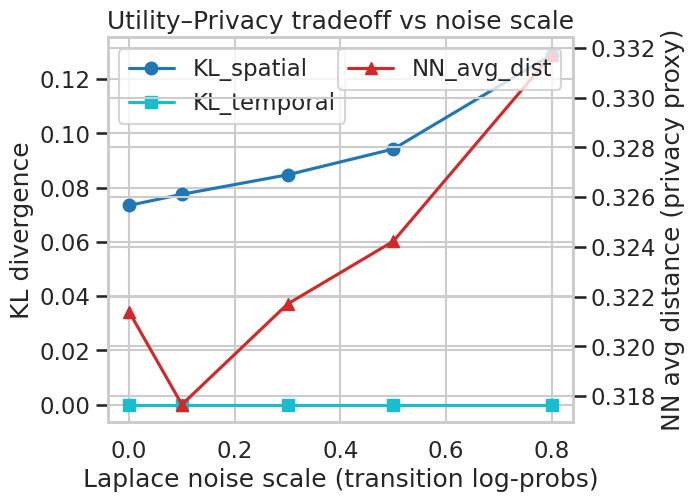

In [12]:
#@title Plot utility–privacy tradeoff
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df_results["laplace_scale"], df_results["KL_spatial"], marker="o", label="KL_spatial", color="tab:blue")
ax.plot(df_results["laplace_scale"], df_results["KL_temporal"], marker="s", label="KL_temporal", color="tab:cyan")
ax.set_xlabel("Laplace noise scale (transition log-probs)")
ax.set_ylabel("KL divergence")
ax2.plot(df_results["laplace_scale"], df_results["NN_avg_dist"], marker="^", color="tab:red", label="NN_avg_dist")
ax2.set_ylabel("NN avg distance (privacy proxy)")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Utility–Privacy tradeoff vs noise scale")
plt.show()


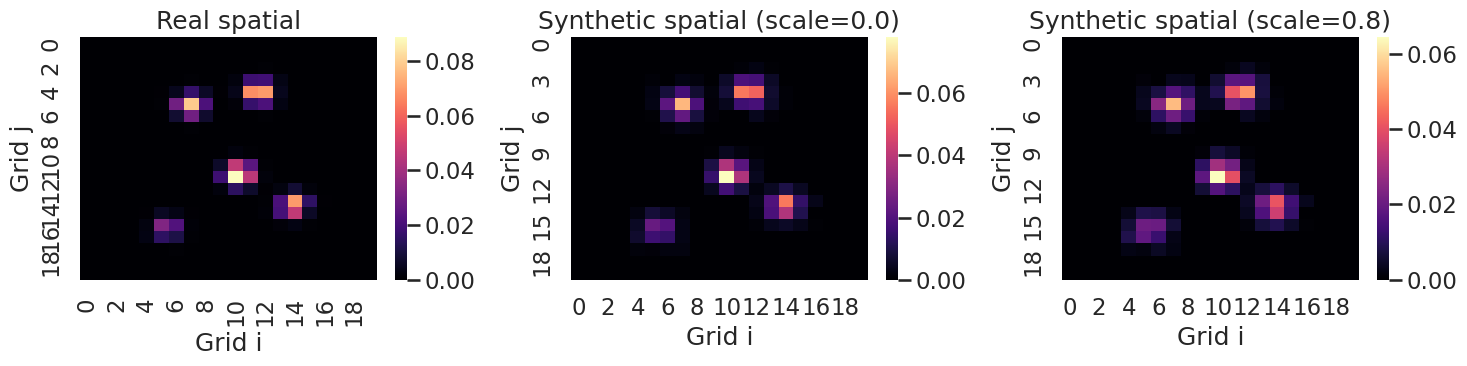

In [13]:
#@title Heatmaps: Real vs Synthetic spatial distributions (one setting)
def plot_spatial_heatmap(vec, grid_size, title):
    mat = vec.reshape((grid_size, grid_size)).T  # transpose for visual orientation
    sns.heatmap(mat, cmap="magma", cbar=True)
    plt.title(title)
    plt.xlabel("Grid i")
    plt.ylabel("Grid j")
    plt.tight_layout()

# Use baseline (s=0.0) and strongest noise (s=0.8) for comparison
def build_synth_for_scale(s):
    init_s, trans_s = estimate_markov(
        disc_real, CONFIG["grid_size"], CONFIG["time_bins"],
        order=CONFIG["markov_order"], laplace_noise_scale=s
    )
    synth_s = batch_generate_synthetic(
        n_trajs=len(disc_real),
        length=CONFIG["synth_len"],
        init=init_s, trans=trans_s,
        ws_spatial=ws_spatial, wt_temporal=wt_temporal,
        time_bins=CONFIG["time_bins"],
        temperature=CONFIG["temperature"]
    )
    return synth_s

synth_low = build_synth_for_scale(0.0)
synth_high = build_synth_for_scale(0.8)

real_sp = spatial_hist(disc_real, num_cells)
low_sp = spatial_hist(synth_low, num_cells)
high_sp = spatial_hist(synth_high, num_cells)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plot_spatial_heatmap(real_sp, CONFIG["grid_size"], "Real spatial")
plt.subplot(1,3,2); plot_spatial_heatmap(low_sp, CONFIG["grid_size"], "Synthetic spatial (scale=0.0)")
plt.subplot(1,3,3); plot_spatial_heatmap(high_sp, CONFIG["grid_size"], "Synthetic spatial (scale=0.8)")
plt.show()


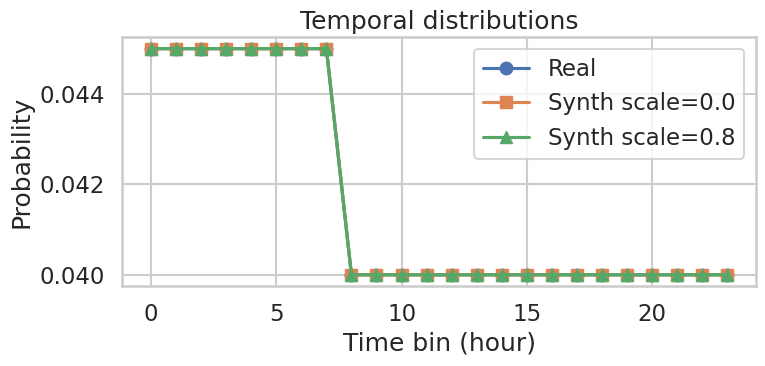

In [14]:
#@title Temporal distribution plots
real_tm = temporal_hist(disc_real, CONFIG["time_bins"])
low_tm  = temporal_hist(synth_low, CONFIG["time_bins"])
high_tm = temporal_hist(synth_high, CONFIG["time_bins"])

plt.figure(figsize=(8,4))
plt.plot(range(CONFIG["time_bins"]), real_tm, marker="o", label="Real")
plt.plot(range(CONFIG["time_bins"]), low_tm, marker="s", label="Synth scale=0.0")
plt.plot(range(CONFIG["time_bins"]), high_tm, marker="^", label="Synth scale=0.8")
plt.xlabel("Time bin (hour)")
plt.ylabel("Probability")
plt.title("Temporal distributions")
plt.legend()
plt.tight_layout()
plt.show()


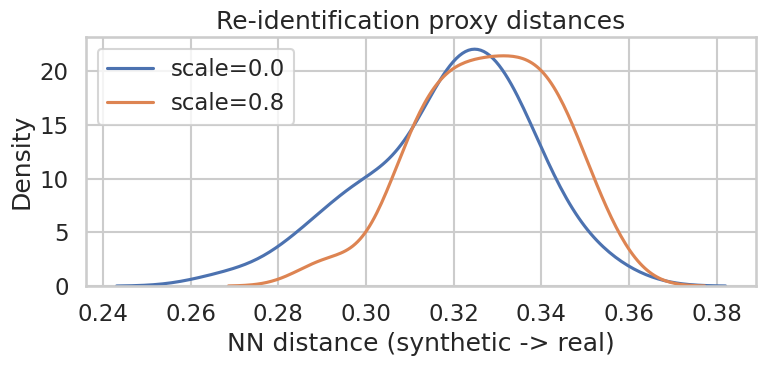

In [15]:
#@title Nearest-neighbor distance distributions (privacy proxy)
def nn_distances(real_disc, synth_disc, num_cells):
    real_vecs = np.vstack([hist_spatial_by_traj(tr, num_cells) for tr in real_disc])
    synth_vecs = np.vstack([hist_spatial_by_traj(tr, num_cells) for tr in synth_disc])
    nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(real_vecs)
    dists, idxs = nbrs.kneighbors(synth_vecs, n_neighbors=1, return_distance=True)
    return dists.flatten()

d_low = nn_distances(disc_real, synth_low, num_cells)
d_high = nn_distances(disc_real, synth_high, num_cells)

plt.figure(figsize=(8,4))
sns.kdeplot(d_low, label="scale=0.0")
sns.kdeplot(d_high, label="scale=0.8")
plt.xlabel("NN distance (synthetic -> real)")
plt.ylabel("Density")
plt.title("Re-identification proxy distances")
plt.legend()
plt.tight_layout()
plt.show()


Final Evaluation (higher Final_score is better overall):
 laplace_scale  KL_spatial  KL_temporal  NN_avg_dist  NN_frac_close_<=0.05  Utility_score  Privacy_score  Final_score
           0.8    0.132308          0.0     0.324996                   0.0       0.500000       1.000000     0.750000
           0.3    0.081137          0.0     0.322084                   0.0       0.913220       0.568089     0.740654
           0.0    0.071524          0.0     0.319920                   0.0       0.990853       0.247266     0.619060
           0.1    0.070391          0.0     0.318950                   0.0       1.000000       0.103337     0.551668
           0.5    0.083701          0.0     0.318253                   0.0       0.892522       0.000000     0.446261

Best tradeoff setting:
- laplace_scale: 0.80
- Utility_score: 0.500 | Privacy_score: 1.000 | Final_score: 0.750
- KL_spatial: 0.1323 | KL_temporal: 0.0000
- NN_avg_dist: 0.3250 (higher means lower re-id risk)


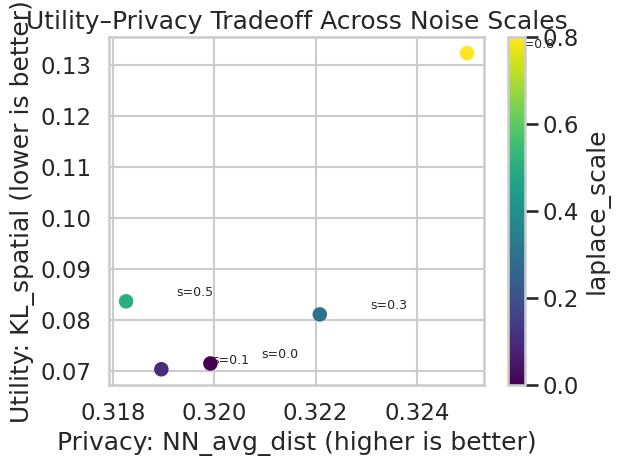

In [18]:
#@title Final Evaluation: One-shot results and best-tradeoff summary

def final_score(df, util_keys=("KL_spatial","KL_temporal"),
                priv_keys=("NN_avg_dist",),
                util_weight=0.5):
    """
    Build a single composite score in [0,1] where higher is better overall.
    - Utility is better when KL is lower; convert via 1 - norm(KL).
    - Privacy is better when NN_avg_dist is higher; use normalized value.
    This is heuristic, just to rank runs.
    """
    X = df.copy()

    # Normalize each metric to [0,1] in a directionally correct way
    # Utility (lower is better): invert after min-max
    for k in util_keys:
        v = X[k].values
        vmin, vmax = np.min(v), np.max(v)
        if np.isclose(vmax, vmin):
            X[f"norm_{k}"] = 1.0  # all equal; treat as perfect utility
        else:
            X[f"norm_{k}"] = 1.0 - (v - vmin)/(vmax - vmin)

    # Privacy (higher is better): direct min-max
    for k in priv_keys:
        v = X[k].values
        vmin, vmax = np.min(v), np.max(v)
        if np.isclose(vmax, vmin):
            X[f"norm_{k}"] = 0.5  # ambiguous; neutral
        else:
            X[f"norm_{k}"] = (v - vmin)/(vmax - vmin)

    # Aggregate utility and privacy
    X["Utility_score"] = X[[f"norm_{k}" for k in util_keys]].mean(axis=1)
    X["Privacy_score"] = X[[f"norm_{k}" for k in priv_keys]].mean(axis=1)

    # Combine with weight (default 50-50)
    X["Final_score"] = util_weight*X["Utility_score"] + (1.0 - util_weight)*X["Privacy_score"]
    return X

def run_quick_eval(scales=(0.0, 0.1, 0.3, 0.5, 0.8),
                   ctx_weight=None, temperature=None,
                   print_table=True, plot_tradeoff=True):
    # Use current CONFIG unless overrides provided
    ctx_w = CONFIG["context_match_weight"] if ctx_weight is None else ctx_weight
    temp  = CONFIG["temperature"] if temperature is None else temperature

    # Precompute marginals and context weights
    num_cells = CONFIG["grid_size"] * CONFIG["grid_size"]
    real_sp = spatial_hist(disc_real, num_cells)
    real_tm = temporal_hist(disc_real, CONFIG["time_bins"])
    ws_sp, wt_tm = build_context_weights(real_sp, real_tm, ctx_w)

    rows = []
    for s in scales:
        # Estimate transitions with privacy noise
        init_s, trans_s = estimate_markov(
            disc_real,
            CONFIG["grid_size"],
            CONFIG["time_bins"],
            order=CONFIG["markov_order"],
            laplace_noise_scale=s
        )
        # Generate synthetic
        synth_s = batch_generate_synthetic(
            n_trajs=len(disc_real)*CONFIG["num_synth_per_user"],
            length=CONFIG["synth_len"],
            init=init_s,
            trans=trans_s,
            ws_spatial=ws_sp,
            wt_temporal=wt_tm,
            time_bins=CONFIG["time_bins"],
            temperature=temp
        )
        # Utility: KL + extras
        util = evaluate_utility(disc_real, synth_s, CONFIG["time_bins"], num_cells)
        # Privacy: NN average distance
        priv = reidentification_risk_proxy(disc_real, synth_s, num_cells, k_neighbors=CONFIG["eval_k_neighbors"])
        rows.append({"laplace_scale": s, **util, **priv})

    df = pd.DataFrame(rows)
    ranked = final_score(df, util_keys=("KL_spatial","KL_temporal"),
                         priv_keys=("NN_avg_dist",),
                         util_weight=0.5).sort_values("Final_score", ascending=False)

    if print_table:
        display_cols = ["laplace_scale",
                        "KL_spatial","KL_temporal",
                        "NN_avg_dist","NN_frac_close_<=0.05",
                        "Utility_score","Privacy_score","Final_score"]
        disp = ranked[display_cols]
        print("Final Evaluation (higher Final_score is better overall):")
        print(disp.to_string(index=False))

        best = ranked.iloc[0]
        print("\nBest tradeoff setting:")
        print(f"- laplace_scale: {best['laplace_scale']:.2f}")
        print(f"- Utility_score: {best['Utility_score']:.3f} | Privacy_score: {best['Privacy_score']:.3f} | Final_score: {best['Final_score']:.3f}")
        print(f"- KL_spatial: {best['KL_spatial']:.4f} | KL_temporal: {best['KL_temporal']:.4f}")
        print(f"- NN_avg_dist: {best['NN_avg_dist']:.4f} (higher means lower re-id risk)")

    if plot_tradeoff:
        # One compact plot: KL_spatial vs NN_avg_dist with labels = noise scale
        plt.figure(figsize=(6.5,5))
        plt.scatter(df["NN_avg_dist"], df["KL_spatial"], c=df["laplace_scale"], cmap="viridis", s=80)
        for _, row in df.iterrows():
            plt.text(row["NN_avg_dist"]+1e-3, row["KL_spatial"]+1e-3, f"s={row['laplace_scale']}", fontsize=9)
        plt.xlabel("Privacy: NN_avg_dist (higher is better)")
        plt.ylabel("Utility: KL_spatial (lower is better)")
        plt.title("Utility–Privacy Tradeoff Across Noise Scales")
        plt.colorbar(label="laplace_scale")
        plt.tight_layout()
        plt.show()

    return ranked

# Run the final evaluation now
final_results = run_quick_eval(
    scales=(0.0, 0.1, 0.3, 0.5, 0.8),
    ctx_weight=CONFIG["context_match_weight"],
    temperature=CONFIG["temperature"],
    print_table=True,
    plot_tradeoff=True
)